# Analyse des données de films et séries télévisées

```markdown
# Analyse des données de films et séries télévisées

Dans ce notebook, nous allons analyser un dataset de films et séries télévisées pour répondre aux questions suivantes:
1. Top 5 des meilleures catégories.
2. Top 5 des réalisateurs.
3. Les dix meilleurs acteurs.
4. Les cinq meilleures séries télévisées avec le plus grand nombre de saisons.
5. Identifier des contenus similaires en faisant correspondre des caractéristiques textuelles.
6. Amazon se concentre-t-il davantage sur les séries télévisées que sur les films ces dernières années ?

Nous utiliserons la bibliothèque pandas pour la manipulation des données et matplotlib pour la visualisation.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('amazon.csv')

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [6]:
categories = df['listed_in'].str.split(',').explode().str.strip()
top_categories = categories.value_counts().head(5)

top_categories


Drama       3687
Comedy      2099
Action      1657
Suspense    1501
Kids        1085
Name: listed_in, dtype: int64

In [7]:
top_directors = df['director'].value_counts().head(5)

top_directors


Mark Knight              113
Cannis Holder             61
Moonbug Entertainment     37
Jay Chapman               34
Arthur van Merwijk        30
Name: director, dtype: int64

In [8]:
actors = df['cast'].str.split(',').explode().str.strip()
top_actors = actors.value_counts().head(10)
top_actors


Maggie Binkley        56
1                     35
Gene Autry            32
Nassar                30
Champion              29
Anne-Marie Newland    25
Prakash Raj           24
Roy Rogers            23
John Wayne            23
Danny Trejo           22
Name: cast, dtype: int64

In [9]:
tv_shows = df[df['type'] == 'TV Show']
tv_shows['seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)
top_tv_shows = tv_shows.sort_values(by='seasons', ascending=False).head(5)
top_tv_shows[['title', 'seasons']]

C:\Users\houss\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,seasons
770,The Amazing Race,29.0
1007,Silent Witness,21.0
840,Survivor,19.0
8071,Top Gear (UK),15.0
3291,America's Next Top Model,14.0


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df['combined_features'] = df['title'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['listed_in'].fillna('') + ' ' + df['director'].fillna('') + ' ' + df['cast'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_content(title, cosine_sim=cosine_sim):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  
    similar_indices = [i[0] for i in sim_scores]
    return df.iloc[similar_indices][['title', 'description']]

get_similar_content('The Grand Seduction')



,title,description
2638,Doctor Blood's Coffin,There is horror in a small Cornish village whe...
4319,Kadaram Kondan,A trainee doctor has just moved to Malaysia wi...
604,The Indian Doctor,The Sharmas struggle to cope with the culture ...
6793,The German Doctor,"Patagonia, 1960. A German doctor meets an Arge..."
1694,Meet Dr. Christian,"In the first movie of the series, we are intro..."
7466,In Bruges,HD. European hit men Colin Farrell and Brendan...
5966,Chittibabu,This story is from 1975 real story narsam pall...
3420,A French Village (English subtitled),In French with English subtitles. This acclaim...
308,Tom Gleeson: Joy,Australia’s 2019 Gold Logie winner. Chief cele...
713,The Confessor,A worldly and urbane priest is forced to chall...


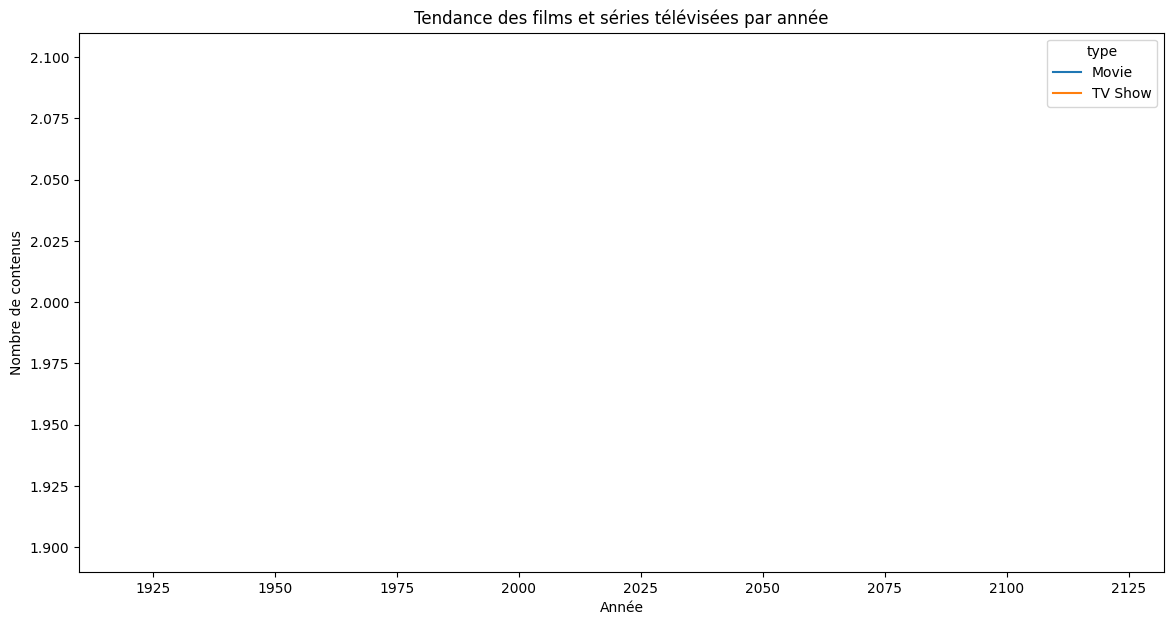

In [39]:
print(df.head())
df['release_year'] = pd.to_datetime(df['date_added']).dt.year

print(df['release_year'].unique())

content_type_year = df.groupby(['release_year', 'type']).size().unstack().fillna(0)

print(content_type_year)

content_type_year.plot(kind='line', figsize=(14, 7))
plt.title('Tendance des films et séries télévisées par année')
plt.xlabel('Année')
plt.ylabel('Nombre de contenus')
plt.show()